### 1. EDA

In [182]:
# import libraries
import pandas as pd

In [183]:
spotify_df = pd.read_csv('./spotify_data.csv', index_col=[0])

In [184]:
spotify_df.columns
# spotify_df[spotify_df['sad'] == 1]

Index(['track_id', 'track_name', 'track_artist', 'lyrics', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'language', 'track+artist', 'sad', 'disgust', 'surprise',
       'fear', 'anger', 'neutral', 'joy'],
      dtype='object')

In [185]:
print(spotify_df[spotify_df['sad']==1].iloc[:,12:23].describe())
print(spotify_df[spotify_df['joy']==1].iloc[:,12:23].describe())

       danceability      energy         key    loudness        mode  \
count    108.000000  108.000000  108.000000  108.000000  108.000000   
mean       0.553843    0.525519    4.944444   -7.072639    0.666667   
std        0.122938    0.178251    3.621930    2.451492    0.473602   
min        0.209000    0.104000    0.000000  -15.326000    0.000000   
25%        0.479000    0.405750    2.000000   -8.322000    0.000000   
50%        0.557000    0.561000    5.000000   -6.907500    1.000000   
75%        0.637000    0.661500    7.250000   -5.385500    1.000000   
max        0.872000    0.886000   11.000000   -2.928000    1.000000   

       speechiness  acousticness  instrumentalness    liveness     valence  \
count   108.000000    108.000000        108.000000  108.000000  108.000000   
mean      0.062081      0.415193          0.010693    0.147436    0.319171   
std       0.060609      0.312026          0.068236    0.095415    0.175552   
min       0.024300      0.001250          0.0000

In [186]:
spotify_df.columns

Index(['track_id', 'track_name', 'track_artist', 'lyrics', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'language', 'track+artist', 'sad', 'disgust', 'surprise',
       'fear', 'anger', 'neutral', 'joy'],
      dtype='object')

In [187]:
# spotify_df['sad']
spotify_df['emotion'] = ''
for emotion in ['sad', 'disgust', 'surprise', 'fear', 'anger', 'neutral', 'joy']:
    spotify_df.loc[spotify_df[emotion]==1, 'emotion'] = emotion
sub_data = pd.concat([spotify_df.iloc[:,12:23], spotify_df.iloc[:,-1]], axis = 1)

In [188]:
x = sub_data.iloc[:,:-1].to_numpy()
y = sub_data[['emotion']].to_numpy()

for idx, i in enumerate(y):
    for key, j in enumerate(['sad', 'disgust', 'surprise', 'fear', 'anger', 'neutral', 'joy']):
        if i == j:
            y[idx] = int(key)

y = y.reshape(317,)
y = y.astype(float)

In [189]:
y.dtype

dtype('float64')

### 2. Feature Selection

In [190]:
import statsmodels.api as sm
x2 = sm.add_constant(x)
fit_p = sm.OLS(y,x2).fit()
print(fit_p.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     33.12
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           8.18e-46
Time:                        11:34:24   Log-Likelihood:                -603.41
No. Observations:                 317   AIC:                             1231.
Df Residuals:                     305   BIC:                             1276.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5104      1.178     -1.282      0.2

In [191]:
# selected variables: X1, x3, x9, x10 - danceability(0.024), key(0.016), liveness(0.010), valence(0.000)
# sub_data.columns
selected_features = sub_data.loc[:, ['danceability', 'key', 'liveness', 'valence']].to_numpy()

In [192]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler

# evlauation metric
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import warnings, sys
warnings.filterwarnings(action="ignore")

# backward setp-wise selection
class backward_selection:
    def __init__(self, X, y):

        # data preprocessing
        self.colnames = X.columns.values.tolist()
        self.tarname = y.name
        X, y = X.to_numpy(), y.to_numpy()
        x_train, x_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.1, random_state=7)
        scaler = StandardScaler()
        self.x_train_scaled = scaler.fit_transform(x_train)
        self.x_test_scaled = scaler.transform(x_test)

        # tools for fitting
        self.n, self.p = self.x_train_scaled.shape
        self.line_fitter = LinearRegression()


    def fit(self, mode):
        kfold = KFold(n_splits = 10, shuffle = True, random_state = 10)
        predictors_selected = [[i for i in range(self.p)]]
        vars_remain = [1 for i in range(self.p)]

        #model fitting
        for i in range(self.p):

            # initialization
            cv_error = sys.float_info.max
            vars = predictors_selected[-1]

            for n, j in enumerate(vars_remain):
                if j!=0:
                    if i == (self.p-1):
                        vars_remain[n] = 0
                        break
                    score = -cross_val_score(self.line_fitter, self.x_train_scaled[:, list(set(vars)-{n})], self.y_train, cv = kfold, scoring = 'neg_mean_squared_error').mean()

                    if score < cv_error:
                        cv_error = score
                        selected_var = n

            # update
            if i == (self.p-1):
                break
            predictors_selected.append(list(set(vars)-{selected_var}))
            vars_remain[selected_var] = 0

        
        print(f'selected models: {predictors_selected}')
        
        # model selection
        # prediction error
        prediction_error = sys.float_info.max
        selected_model = -1
        for n in range(len(predictors_selected)):
            self.line_fitter.fit(self.x_train_scaled[:,predictors_selected[n]], self.y_train)
            
            y_predict = self.line_fitter.predict(self.x_test_scaled[:,predictors_selected[n]])
            _prediction_error = mean_squared_error(self.y_test, y_predict)
            # print(_prediction_error)
            if prediction_error > _prediction_error:
                prediction_error = _prediction_error
                selected_model = n
                # print(selected_model)

        # AIC

        # BIC

        # Adj.R
        
        # report
        if mode == 'cv':
            self.selected_model = [i for (n, i) in enumerate(self.colnames) if n in predictors_selected[selected_model]]
            print(f'Backward_selection model: {self.tarname} ~ {[i for (n, i) in enumerate(self.colnames) if n in predictors_selected[selected_model]]}.')
            

In [193]:
sub_data['emotion'] = sub_data['emotion'].apply(lambda e: next(idx for idx, val in enumerate(['sad', 'disgust', 'surprise', 'fear', 'anger', 'neutral', 'joy']) if e == val))

In [194]:

model = backward_selection(sub_data.iloc[:,:-1],sub_data.iloc[:,-1])
model.fit('cv')
backward_selection_predictors = model.selected_model

selected models: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 4, 5, 6, 8, 9, 10], [0, 1, 2, 4, 5, 6, 8, 9], [0, 1, 2, 4, 6, 8, 9], [0, 1, 2, 6, 8, 9], [0, 2, 6, 8, 9], [8, 9, 2, 6], [9, 2, 6], [9, 6], [9]]
Backward_selection model: emotion ~ ['acousticness', 'valence'].


### 3. Visualization

In [195]:
# t-SNE dataviz

features = sub_data.iloc[:,:-1].to_numpy()
targets = sub_data.iloc[:,-1].to_numpy()
print(features.shape, targets.shape)

# load tsne module and build a model
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
n_components = 2 # 2차원으로 차원 축소
tsne_model = TSNE(n_components = n_components)


(317, 11) (317,)


(317, 2)


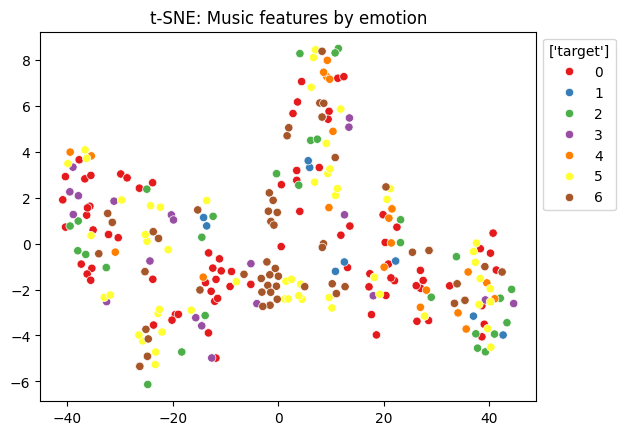

In [196]:
results = tsne_model.fit_transform(features)
print(results.shape)
palette = sns.color_palette('Set1', len(set(targets)))
graph = sns.scatterplot(x = results[:,0], y = results[:,1], hue = targets, palette = palette)
plt.title('t-SNE: Music features by emotion')
plt.legend(title = ['target'])
sns.move_legend(graph, 'upper left', bbox_to_anchor = (1,1))
plt.show()

In [197]:
# Normalize the featuers by each class
import numpy as np
def softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x
es_sample = softmax(np.random.randn(1,7))# sample emotion score
es_sample 

array([[0.02705005, 0.0342272 , 0.05711862, 0.2294358 , 0.01302259,
        0.12739959, 0.51174615]])

(317, 2)


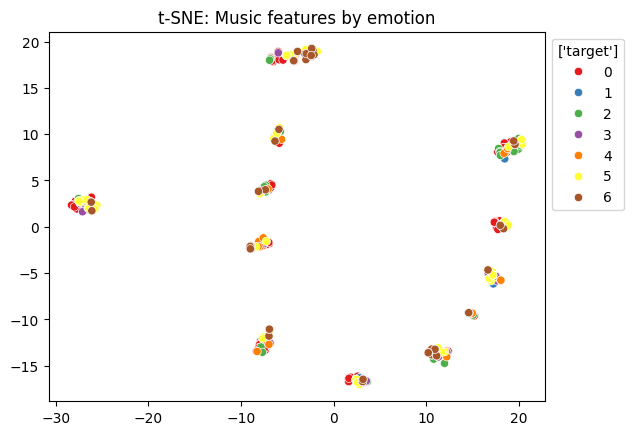

In [198]:
# T-sne plot for selected features
n_components = 2 # 2차원으로 차원 축소
tsne_model = TSNE(n_components = n_components)
results = tsne_model.fit_transform(selected_features)
print(results.shape)
palette = sns.color_palette('Set1', len(set(targets)))
graph = sns.scatterplot(x = results[:,0], y = results[:,1], hue = targets, palette = palette)
plt.title('t-SNE: Music features by emotion')
plt.legend(title = ['target'])
sns.move_legend(graph, 'upper left', bbox_to_anchor = (1,1))
plt.show()

(317, 2)


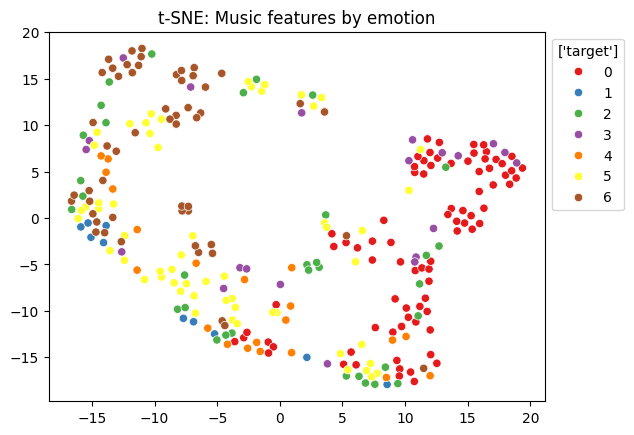

In [199]:
# selected variables: valence, acousticness
# sub_data.columns
selected_features = sub_data.loc[:, ['acousticness', 'valence']].to_numpy()

# T-sne plot for selected features
n_components = 2 # 2차원으로 차원 축소
tsne_model = TSNE(n_components = n_components)
results = tsne_model.fit_transform(selected_features)
print(results.shape)
palette = sns.color_palette('Set1', len(set(targets)))
graph = sns.scatterplot(x = results[:,0], y = results[:,1], hue = targets, palette = palette)
plt.title('t-SNE: Music features by emotion')
plt.legend(title = ['target'])
sns.move_legend(graph, 'upper left', bbox_to_anchor = (1,1))
plt.show()